In [2]:
import glob, os, pandas as pd, numpy as np, matplotlib.pyplot as plt

from itertools import product

if not os.path.isdir('statistics'):
    os.mkdir('statistics')

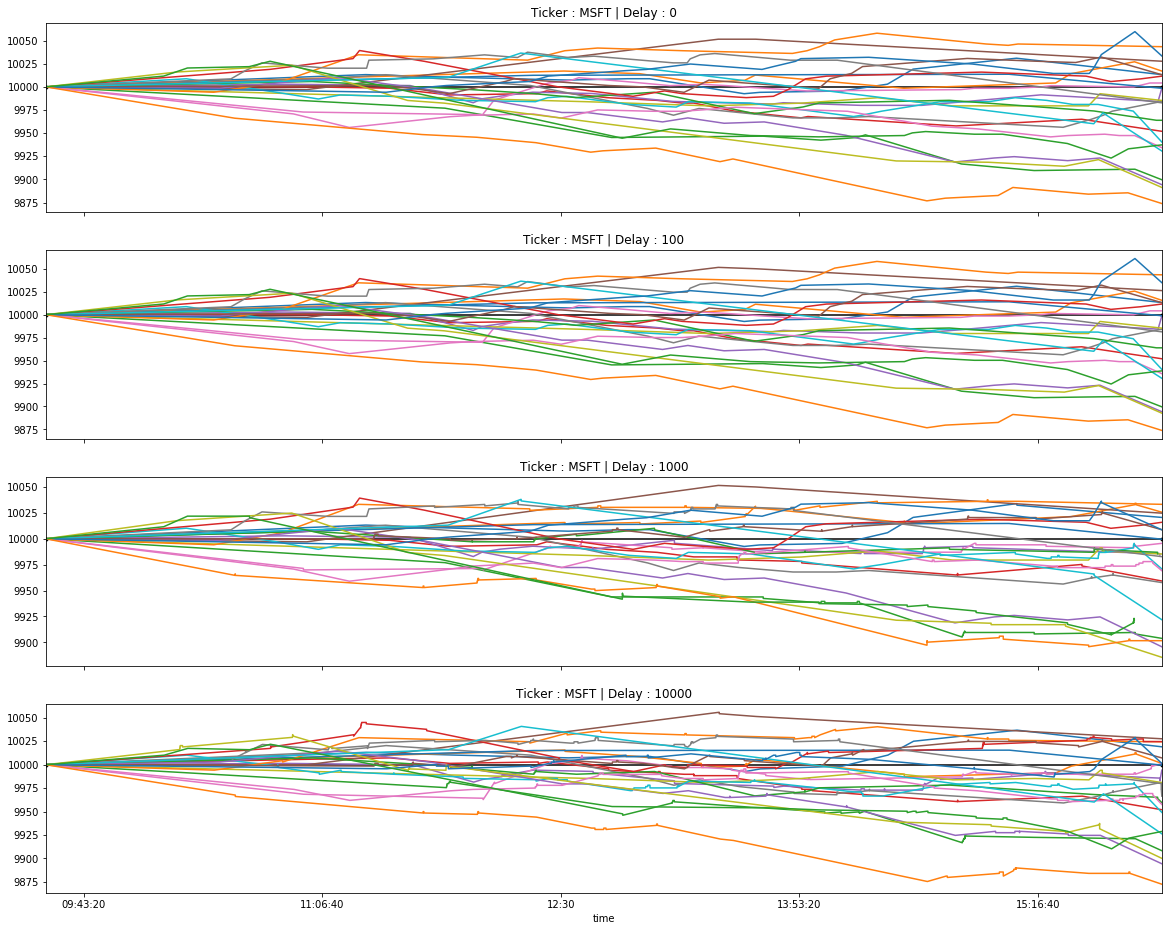

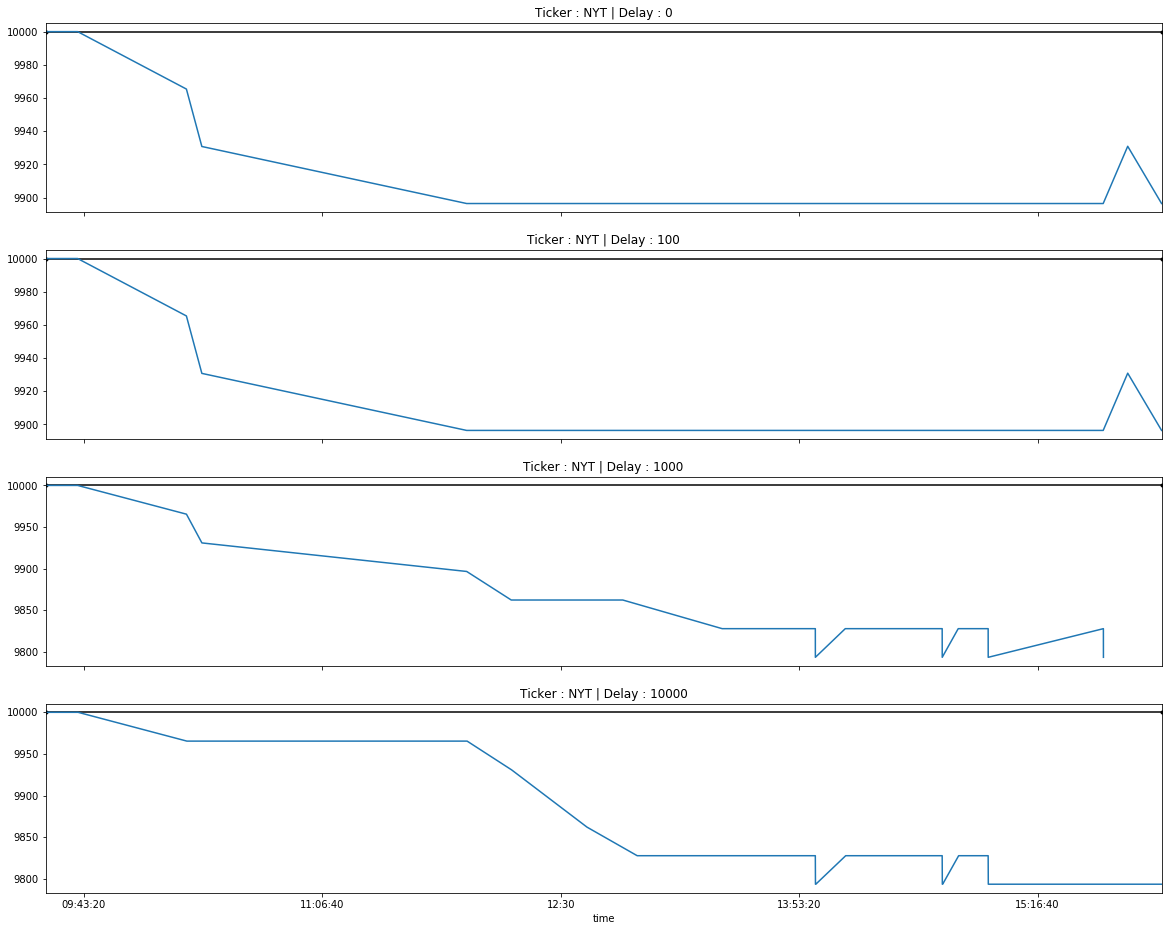

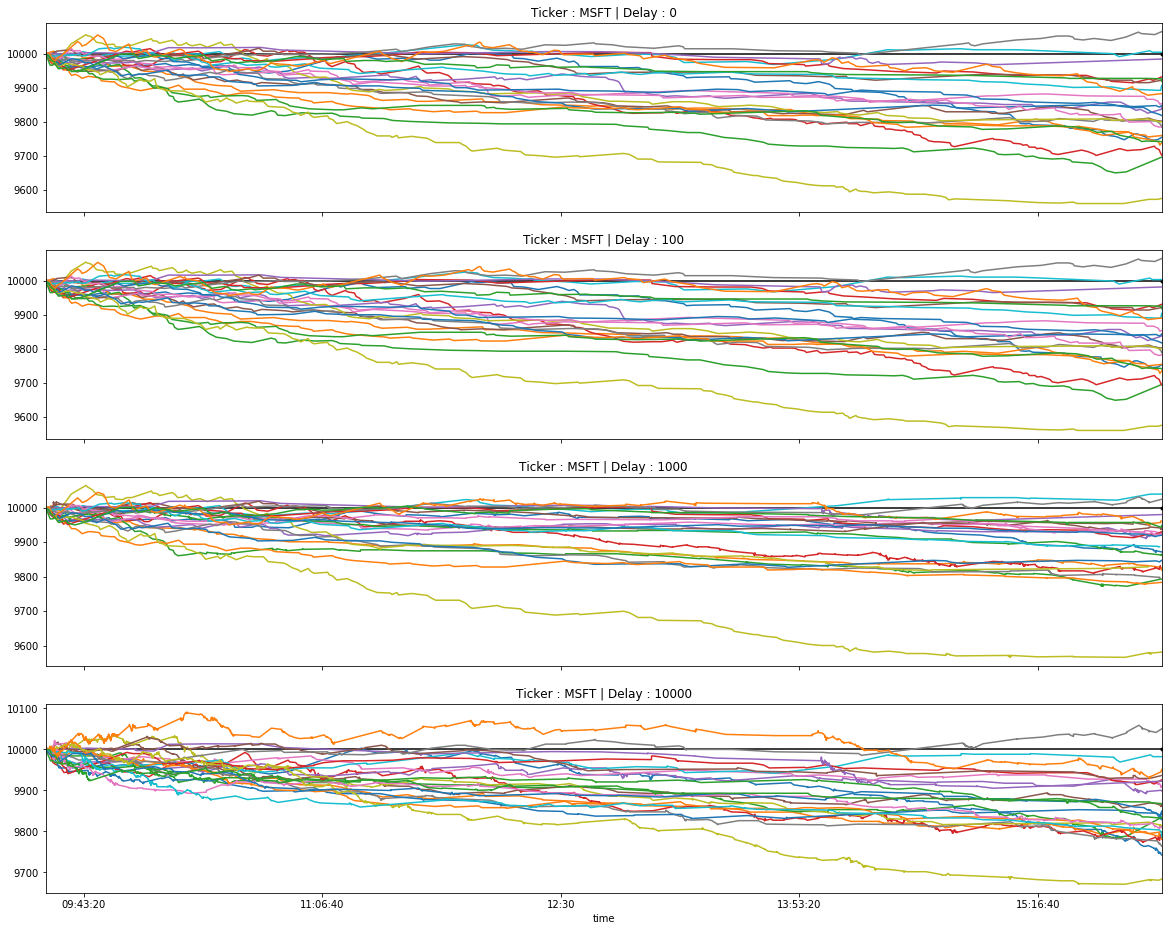

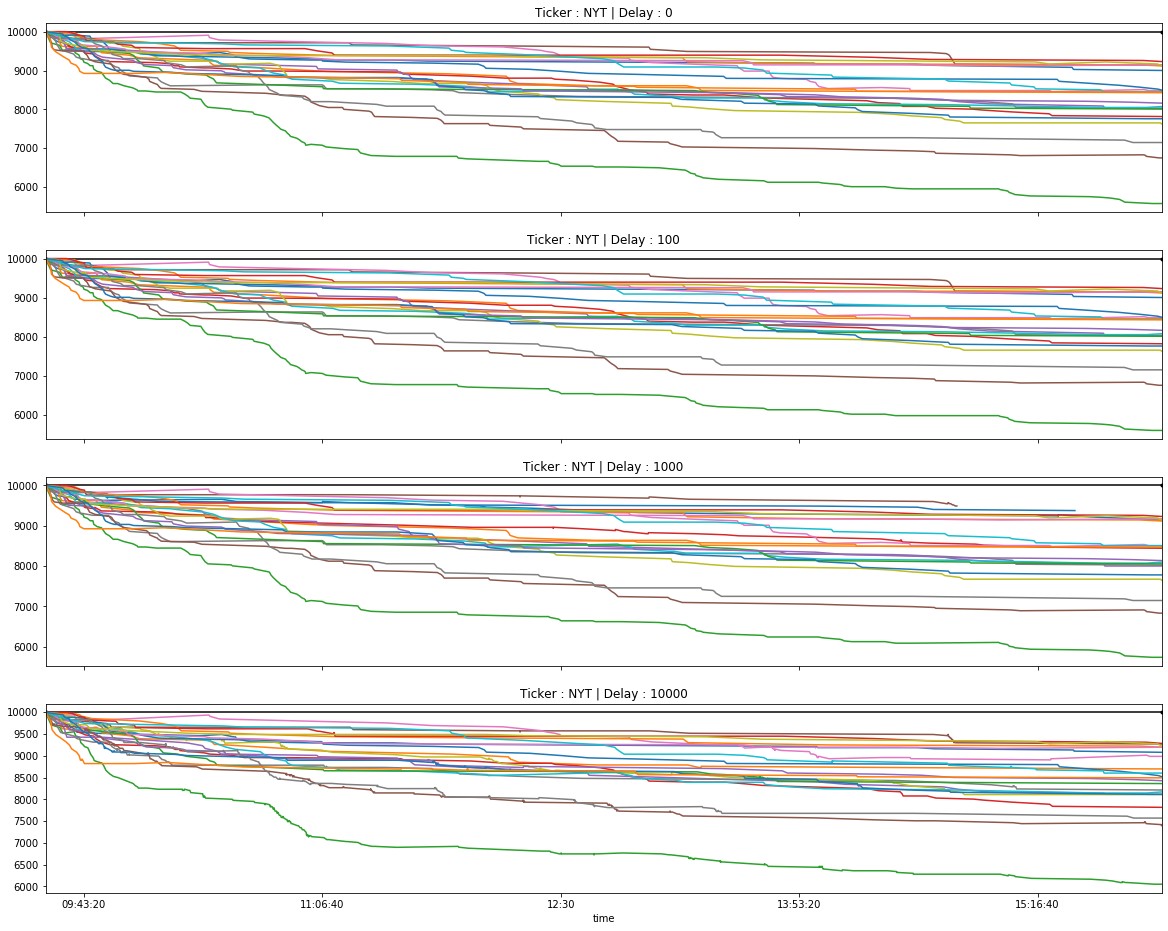

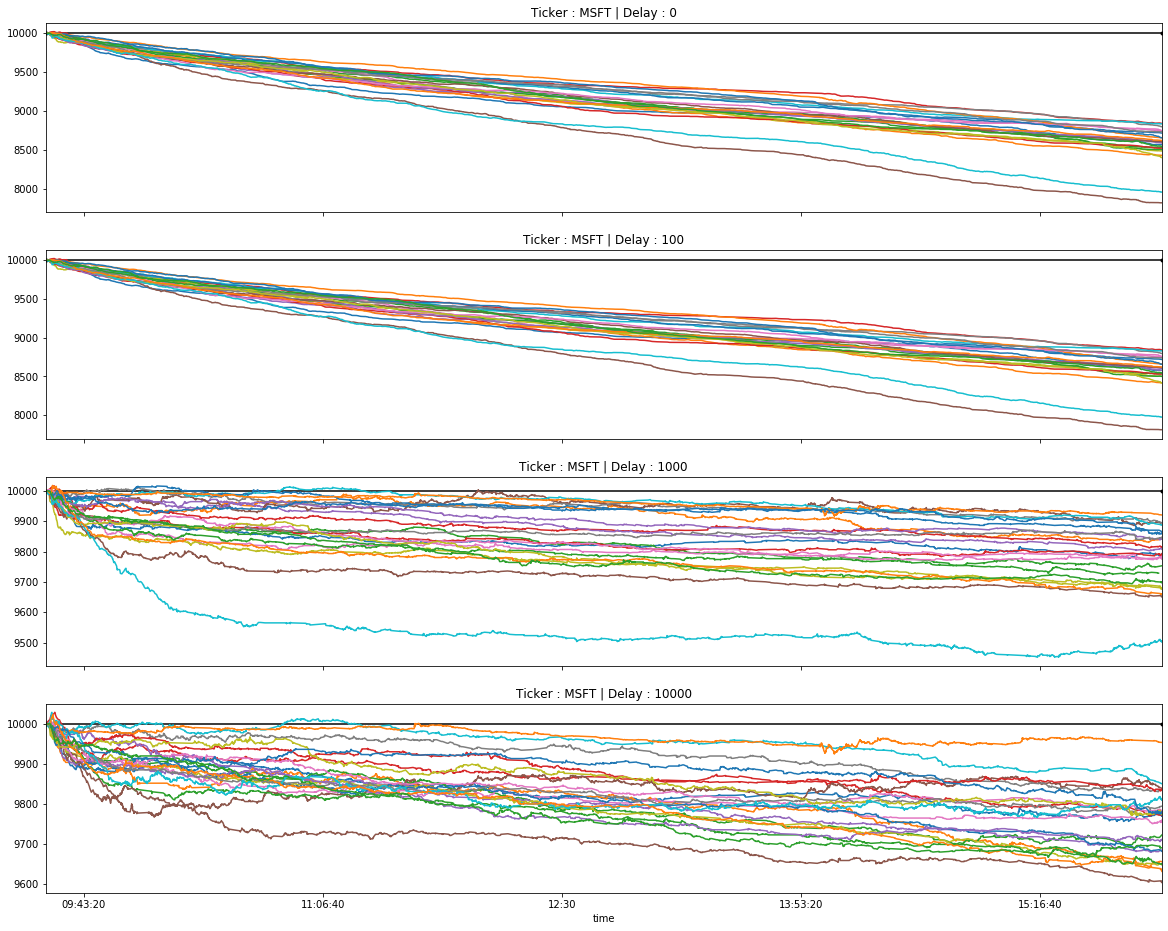

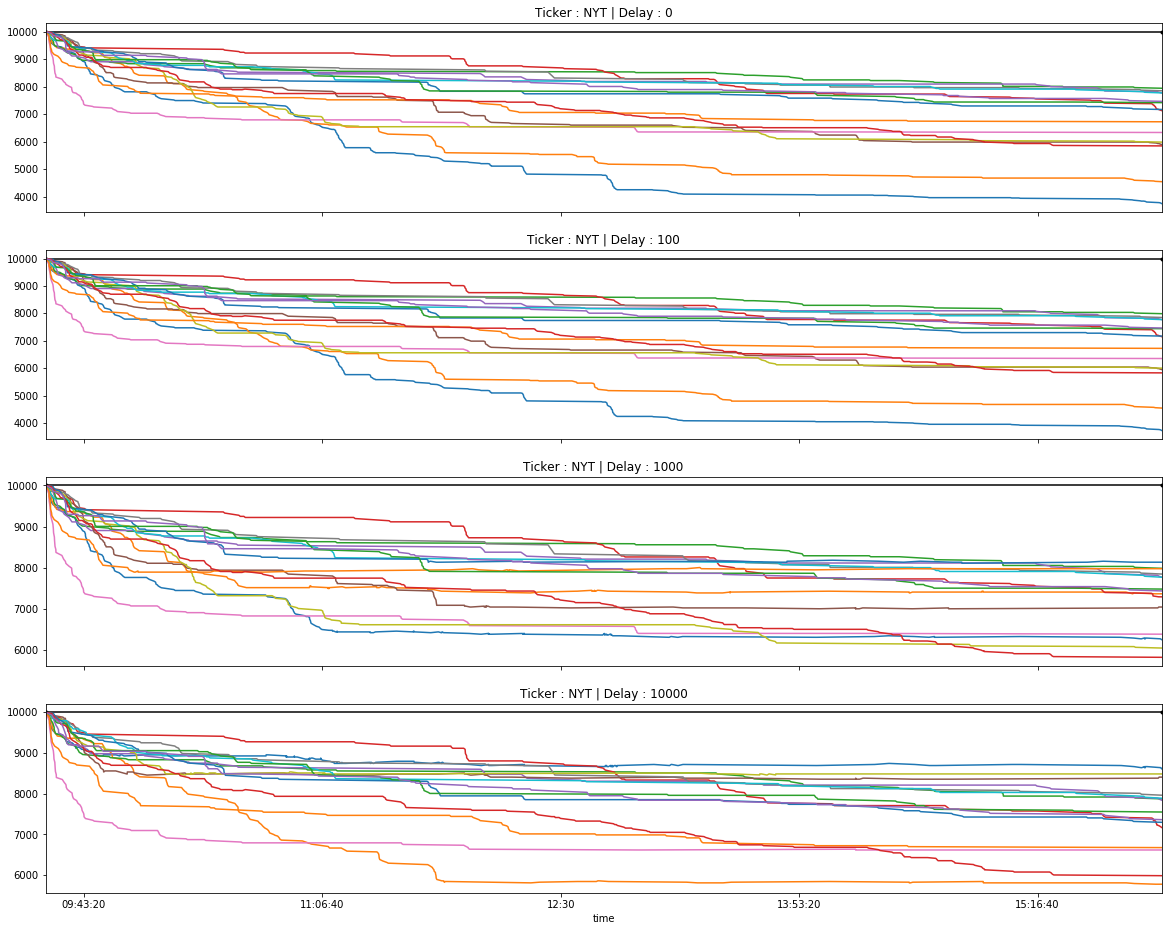

        RSI|MSFT  RSI|NYT  MA|MSFT  MA|NYT  MP|MSFT  MP|NYT
SIGNAL                                                     
Sell       21326     5380    53111   27999   222976   21013
Buy        17613     8453    54159   29806   214609   19981
       RSI|MSFT   RSI|NYT   MA|MSFT    MA|NYT   MP|MSFT    MP|NYT
0     -0.002912 -0.010357 -0.016920 -0.181739 -0.144255 -0.336035
100   -0.002904 -0.010357 -0.016920 -0.181660 -0.144154 -0.335118
1000  -0.002791  0.958621 -0.140282 -0.170454 -0.063676 -0.275591
10000 -0.003145 -0.020653 -0.014676 -0.159460 -0.067175 -0.256601
       RSI|MSFT  RSI|NYT   MA|MSFT    MA|NYT   MP|MSFT    MP|NYT
0      0.004892      0.0  0.010999  0.086173  0.023844  0.121093
100    0.004867      0.0  0.011051  0.085932  0.023841  0.121702
1000   0.004505      0.0  0.441587  0.089049  0.454053  0.073467
10000  0.004486      0.0  0.008291  0.074914  0.199051  0.083617


In [8]:
strategy_names = ['RSI', 'MA', 'MP']

tickers = ['MSFT', 'NYT']

delays = [0, 100, 1000, 10000]

stats_list = []
returns_list = []
std_list = []

combinations = product(strategy_names, tickers)
for combination in combinations:
#     print(combination)
    (strategy, ticker) = combination
    
    # signals stats
    filenames = glob.glob('output/' + ticker + "_" + strategy + "_signals_*.csv")
    
    df_list = []
    for filename in filenames:
        df_list.append(pd.read_csv(filename))
    
    
    df_combined = pd.concat(df_list)

    df_combined['TIME'] = pd.to_datetime(df_combined['TIME']).dt.date

    stats = df_combined.groupby('SIGNAL')['TIME'].count()

    stats.name = strategy + "|" + ticker

    stats.rename(lambda x: "Sell" if x==-1 else "Buy", inplace=True)

    stats_list.append(stats)
        
    
    
    
    #tradebook stats
    filenames = glob.glob('output/' + ticker + "_" + strategy + "_tradebook_*.csv")
    
    returns = {delay : [] for delay in delays}
    
    for filename in filenames:
        tradebook = pd.read_csv(filename, index_col=0)
#         date = filename.split("_")[-1].split(".")[0]
        
        for delay in delays:
            series = tradebook['OUTSTANDING_BALANCE_' + str(delay)].dropna().sort_index(ascending=True)
            
            returns[delay] += [(series[-1] - series[0])/series[0]]
            

        
    return_series = pd.Series({delay: np.mean(returns[delay]) for delay in delays})
    return_series.name = strategy + "|" + ticker
    
    returns_list.append(return_series)
    
    std_series = pd.Series({delay: np.std(returns[delay]) for delay in delays})
    std_series.name = strategy + "|" + ticker
    
    std_list.append(std_series)
    
    
    
    
    # Plot the returns
    filenames = glob.glob('output/' + ticker + '_' + strategy + '_tradebook_*.csv')

    fig, axs = plt.subplots(nrows=len(delays), ncols=1, figsize=(20,16), sharex=True)

    for delay, ax in zip(delays, axs):
        ax.axhline(y=10000, c='black', marker='.')
        ax.set_title("Ticker : " + ticker + " | Delay : " + str(delay))

    for file in filenames:
        tradebook = pd.read_csv(file, index_col=0)
        tradebook.index = pd.to_datetime(tradebook.index).time

        for delay, ax in zip(delays, axs.flatten()):
            series_balance = tradebook["OUTSTANDING_BALANCE_" + str(delay)]
            series_inventory = tradebook["OUTSTANDING_INVENTORY_" + str(delay)]
            series_balance = series_balance[series_inventory==0]
            series_balance.sort_index(ascending=True, inplace=True)
            series_balance.plot(ax=ax)

    plt.xlim(series_balance.index[0], series_balance.index[-1])   

    plt.savefig(os.path.join('statistics', ticker + '_' + strategy + '_tradebook.jpg'))
    plt.show()   
      
trade_stats_combined = pd.concat(stats_list, axis=1)
returns_combined = pd.concat(returns_list, axis=1)
std_combined = pd.concat(std_list, axis=1)

print(trade_stats_combined)
print(returns_combined)
print(std_combined)

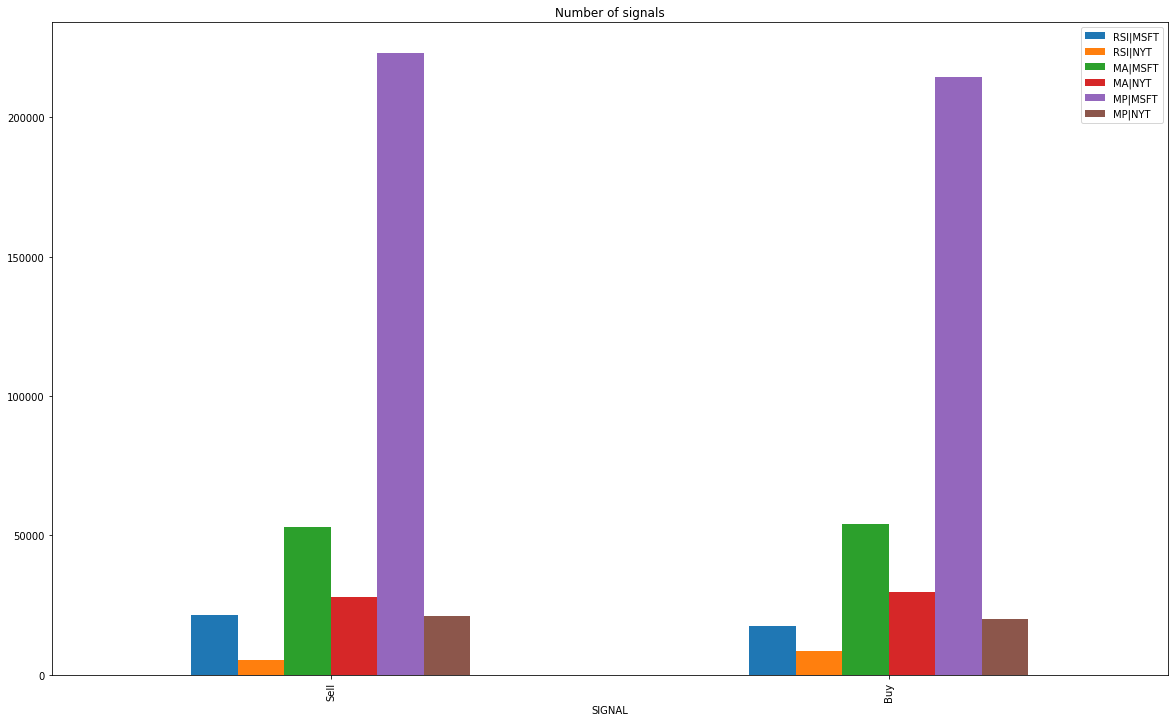

In [9]:
trade_stats_combined.plot.bar(figsize=(20,12))

plt.title('Number of signals')
# plt.xlabel('Buy/Sell')
# plt.ylabel('Returns')

plt.savefig(os.path.join('statistics', 'number_of_signals_bar.jpg'), format='jpeg')




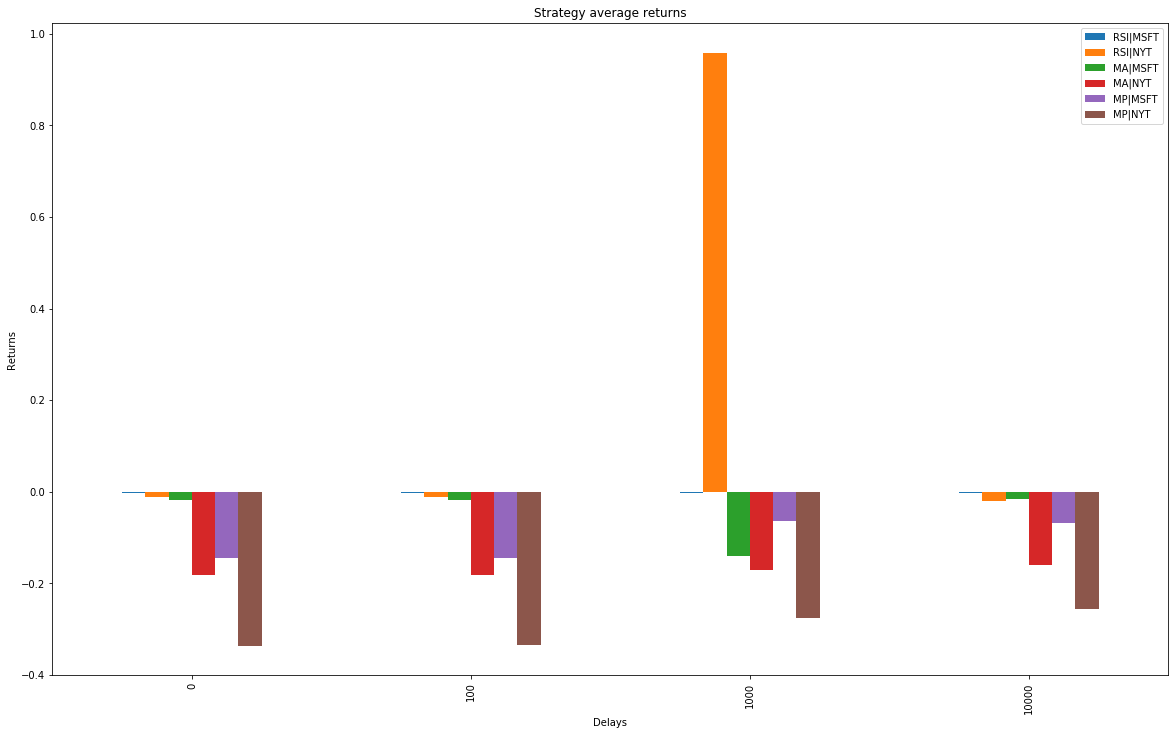

In [10]:
returns_combined.plot.bar(figsize=(20,12))

plt.title('Strategy average returns')
plt.xlabel('Delays')
plt.ylabel('Returns')

plt.savefig(os.path.join('statistics', 'strategy_returns_bar.jpg'), format='jpeg')



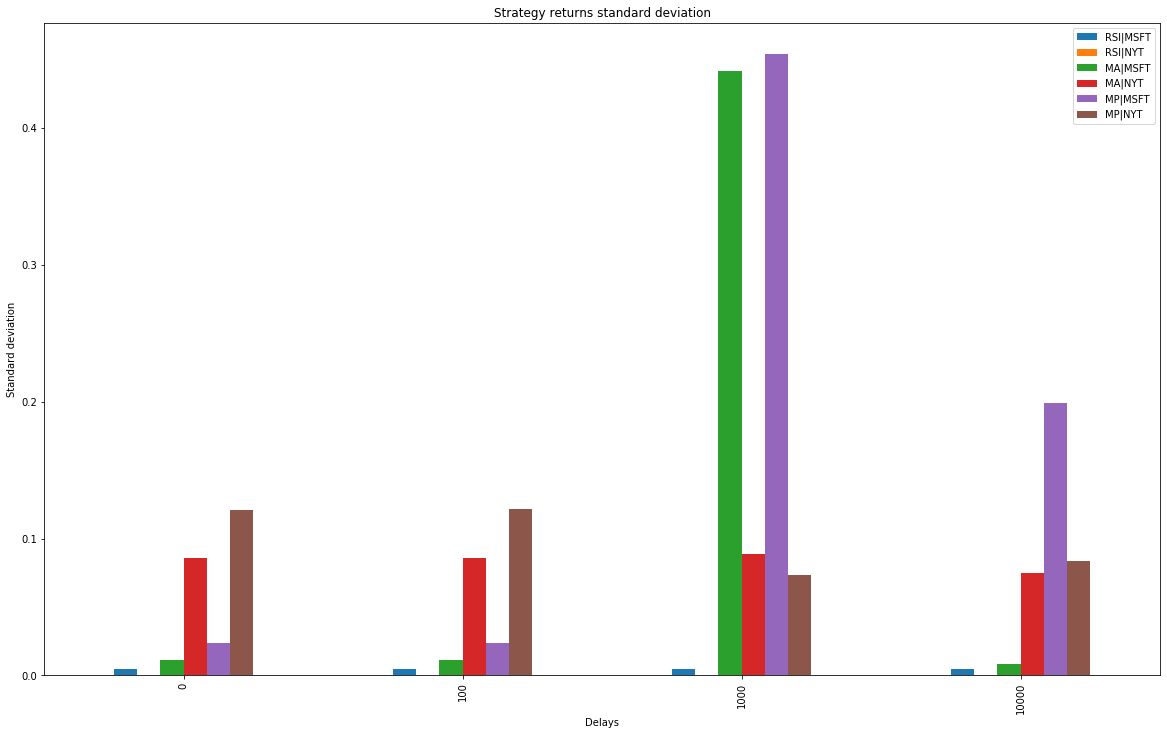

In [11]:
std_combined.plot.bar(figsize=(20,12))

plt.title('Strategy returns standard deviation')
plt.xlabel('Delays')
plt.ylabel('Standard deviation')

plt.savefig(os.path.join('statistics', 'strategy_std_bar.jpg'), format='jpeg')


